Use flight test data to update the Cl_r and Cn_beta aerodynamic coefficients in the simulation model so it can better match the real life flight.

Objective Function:
https://en.wikipedia.org/wiki/Residual_sum_of_squares

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib
import csv

In [87]:
# Read in the flight data
time_data = []
rudder_data = []
yaw_data = []

with open('data.csv',newline='') as file:
    data_reader = csv.reader(file,delimiter='\t')
    for col in data_reader:
        time_data.append(col[0])
        rudder_data.append(col[1])
        yaw_data.append(col[2])

# popping labels out
time_data.pop(0)
rudder_data.pop(0)
yaw_data.pop(0)
time_data = [float(x) for x in time_data]
rudder_data = [float(x) for x in rudder_data]
yaw_data = [float(x) for x in yaw_data]

In [67]:
# Vehicle Geometry
S = 24 # Wing area, [m^2]
b = 8.4 # Wing span [m]
m = 7900 # mass [kg]
Ixx = 10970 # moments of intertia [kg.m^2]
Izz = 39600
Ixz = 1760
c0 = 1.0/(Ixx*Izz - Ixz**2)
c3 = c0*Izz
c4 = c0*Ixz
c10 = c0*Ixx

In [68]:
# Flight Conditions
g = 9.81 # gravity [m/s^2]
v = 190 # airspeed [m/s]
rho = 0.77 # density [kg/m^3]
qbar = 0.5*rho*v**2 # dynamic pressure [N/m^2]

In [69]:
# Aerodynamic Coefficients
Cyb, Cydr = -1.0, 0.17
Clb, Clp, Clr, Cldr = -0.13, -0.25, 0.16, 0.04
Cnv, Cnp, Cnr, Cndr = 0.26, 0.025, -0.37, -0.11

In [70]:
# Equations of Motion
def EOM(x):
    beta = x[0] # sideslip [rad]
    p = x[1] # roll rate   [rad/s]
    r = x[2] # yaw rate [rad/s]
    phi = x[3] # roll angle [rad]
    psi = x[4] # heading angle [rad]
    rud = x[5] # rudder angle [rad]
    
    pn = 0.5*p*b/v # normalized roll rate [rad]
    rn = 0.5*r*b/v # normalized yaw rate [rad]
    
    Cy = Cyb*beta + Cydr*rud
    Cl = Clb*beta + Clp*pn + Clr*rn + Cldr*rud
    Cn = Cnb*beta + Cnp*pn + Cnr*rn + Cndr*rud
    
    Fy = qbar*S*Cy
    L = qbar*S*b*Cl
    N = qbar*S*b*Cn
    
    dbeta = (Fy/m + g*math.sin(phi))/v - r
    dp = c3*L + c4*N
    dr = c4*L + c10*N
    dphi = p
    
    dpsi = r*math.cos(phi)
    
    dxdt = []
    dxdt.append(dbeta)
    dxdt.append(dp)
    dxdt.append(dr)
    dxdt.append(dphi)
    dxdt.append(dpsi)
    dxdt.append(0.0) # constant rudder
    
    return dxdt

In [71]:
# 4th order Runge-kutta
def rk45(x):
    size = len(x)
    rn = []
    for i in range(size):
        rn.append(x[i])
    r1 = EOM(rn)
    for i in range(size):
        rn[i] = x[i]+0.5*dt*r1[i]
    r2 = EOM(rn)
    for i in range(size):
         rn[i] = x[i]+0.5*dt*r2[i]
    r3 = EOM(rn)
    for i in range(size):
        rn[i] = x[i]+dt*r3[i]
    r4 = EOM(rn)
    for i in range(size):
        rn[i] = x[i] + (dt/6.0)*(r1[i]+2*r2[i]+2*r3[i]+r4[i])
        
    return rn

In [72]:
# Calculate time step from the data
dt = time_data[1] - time_data[0]
dt = dt/5.0 # integrate 5 times between data points


In [86]:
# find best parameters
min_error = 10000
Clr_min = 0.0
Cnb_min = 0.0

# Guess the range of Clr and Cnb and increase by tenths 
# calculate the error then use the rudder data to propagate
# the model and see how yaw data changes
for Clri in range(1,20):
    Clr = 0.01*float(Clri)
    for Cnbi in range(1,30):
        Cnb = 0.01*float(Cnbi)
        y_error = 0.0
        x = [0.0]*6
        
        for j in range(len(time_data)):
            yaw_sim = x[2]*180/math.pi
            # objective function
            y_error += (yaw_data[j]-yaw_sim)**2
            x[5] = (math.pi/180)*rudder_data[j]
            
            for i in range(5):
                x = rk45(x)
                
        if (y_error < min_error):
            min_error = y_error
            Clr_min = Clr
            Cnb_min = Cnb

In [83]:
print('obj Function:',min_error)
print('Clr:',Clr)
print('Cnb',Cnb_min)

obj Function: 20.865577989072165
Clr: 0.19
Cnb 0.1


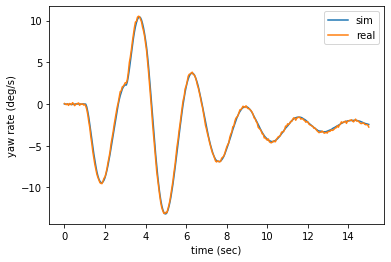

In [85]:
# Plotting
x = [0.0]*6
Clr = Clr_min
Cnb = Cnb_min

yrates = []
times = []

time = time_data[0]
for j in range(len(time_data)):
    yaw_sim = x[2]*180/math.pi
    yrates.append(yaw_sim)
    times.append(time)
    
    x[5] = (math.pi/180)*rudder_data[j]
    
    for i in range(5):
        x = rk45(x)
        time += dt
        
plt.plot(times,yrates,label='sim')
plt.plot(time_data,yaw_data,label='real')
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('yaw rate (deg/s)')
plt.show()